# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Цель исследования** — определение наиболее прибыльного тарифа и проверка двух гипотез:

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Описание тарифов

**Тариф «Смарт»**

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 
   - минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
   - сообщение: 3 рубля; 
   - 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 
   - минута разговора: 1 рубль; 
   - сообщение: 1 рубль; 
   - 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Ход исследования**

Данные о звонках находятся в файле `calls.csv`, информация об интернет-сессиях в `internet.csv`, данные о сообщениях в `messages.csv`, информация о тарифах в `tariffs.csv`, информация о пользователях в `users.csv`. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных. 

На этапе предобработки необходимо будет определить и обработать пропуски, проверить наличие дубликатов, привести данные в столбцах к нужным типам, оценить данные на наличие в них аномалий.

Необходимо дополнить таблицу и для каждого пользователя посчитать:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

На этапе анализа данных необходимо будет описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.

Выполнить проверку гипотез.
 
Таким образом, исследование пройдёт в пять этапов:
 1. Обзор данных;
 2. Предобработка данных;
 3. Расчёты и добавление результатов в таблицу;
 4. Исследовательский анализ данных;
 5. Проверка гипотез.

## Шаг 1. Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv').drop(['Unnamed: 0'],axis = 1)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')
list_of_dfs = [calls, internet, messages, tariffs, users]
for df in list_of_dfs:
    print('__________________________________')
    display(df.head(10))
    df.info()
    display(df.describe())

__________________________________


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


__________________________________


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


__________________________________


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


__________________________________


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


__________________________________


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Таблица **users** (информация о пользователях):

* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

Таблица **calls** (информация о звонках):

* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица **messages** (информация о сообщениях):

* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях):

* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица **tariffs** (информация о тарифах):

* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Замечания к данным:**
1. Пропуски в таблице **users** в столбце `churn_date` связаны с тем, что тариф ещё действует. Заменим пропуски нулём;
2. В столбцах с датами заменить тип данных на Datetime;
2. Необходимо округлить значения в столбцах с минутами и мегабайтами в большую сторону в соответствии с правилами оператора, а затем преобразовать их в целочисленный тип;
3. Проверить, есть ли в данных дубликаты и удалить их;
4. Проверить категориальные значения и количественные значения в датафрейме.

**Вывод**

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Следует их предобработать, проверить наличие дубликатов и устранить проблемы в данных.

## Шаг 2. Предобработка данных

Рассмотрим отдельно каждую таблицу

#### 2.1. Таблица `users`

In [3]:
users.info()
users.head(10)
display(users.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Рассмотрим столбец `user_id`. Оценим число уникальных значений в столбце. Все значения в этом столбце должны быть уникальными.

In [4]:
len(users['user_id'].unique())

500

In [5]:
users['user_id'].describe()

count     500.000000
mean     1249.500000
std       144.481833
min      1000.000000
25%      1124.750000
50%      1249.500000
75%      1374.250000
max      1499.000000
Name: user_id, dtype: float64

Столбец в порядке. Всего 500 уникальных значений id от 1000 до 1499.

Рассмотрим столбец `age`

In [6]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Столбец `age` также в порядке, в нем хранятся значения от 18 до 75. Пропусков нет.

Рассмотрим столбец `churn_date`

In [7]:
users['churn_date'].describe()

count             38
unique            33
top       2018-10-03
freq               2
Name: churn_date, dtype: object

В столбце много пропусков, но они связаны с тем, что тариф все ещё действует, поэтому оставим пропуски как есть.
Изменим тип данных на Datetime

In [8]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
display(users.query('churn_date.isna() == False').head(10))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Изменение типа данных проведено успешно

Рассмотрим столбец `city`

In [10]:
users['city'].describe()

count        500
unique        76
top       Москва
freq          99
Name: city, dtype: object

Рассмотрим список уникальных значений на наличие скрытых дубликатов.

In [11]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Скрытых повторов нет, данные в порядке

Столбцы `first_name` и `last_name` рассматривать не имеет смысла, они могут быть любыми и в исследовании не участвуют.

Рассмотрим столбец `reg_date` и изменим тип данных на Datetime

In [12]:
users['reg_date'].describe()

count            500
unique           270
top       2018-05-28
freq               8
Name: reg_date, dtype: object

In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Изменение типа данных проведено успешно

Рассмотрим столбец `tariff`. Рассмотрим уникальные значения и их число в таблице.

In [15]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Рассмотрим всю таблицу снова

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Данные в порядке

#### 2.2. Таблица `calls`

In [17]:
display(calls.info())
display(calls.head(10))
display(calls.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Рассмотрим столбец `id`

In [18]:
calls['id'].value_counts()

1100_463    1
1251_339    1
1330_101    1
1340_522    1
1154_200    1
           ..
1462_199    1
1380_328    1
1232_0      1
1375_769    1
1353_364    1
Name: id, Length: 202607, dtype: int64

Всего 202607 значений и все уникальные.

Рассмотрим столбец `call_date` и заменим тип данных на Datetime

In [19]:
calls['call_date'].describe()

count         202607
unique           365
top       2018-12-31
freq            1435
Name: call_date, dtype: object

365 уникальных значений по числу дней в году

In [20]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Изменение типа данных проведено успешно

Рассмотрим столбец `duration`, округлим в большую сторону и изменим тип данных на целочисленный

In [21]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Выбросов нет. Длительность вызовов от 0 до 38 минут (0 минут - это пропущенные звонки)

Проведем округление в большую сторону и изменим тип данных

In [22]:
calls['duration'] = calls['duration'].apply(math.ceil).astype(int)
display(calls['duration'])

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

Рассмотрим столбец `user_id`

In [23]:
calls['user_id'].value_counts()

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64

Некоторые абоненты делали свыше 1000 звонков в год. Это могут быть колл-центры. 8 абонентов за год не разговаривали ни разу, что вполне может быть

Рассмотрим таблицу снова

In [24]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


#### 2.3. Таблица `messages`

In [25]:
messages.info()
display(messages.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Рассмотрим столбец `id`

In [26]:
messages['id'].value_counts()

1424_484    1
1145_495    1
1004_237    1
1033_35     1
1266_195    1
           ..
1165_391    1
1423_333    1
1418_69     1
1468_6      1
1353_364    1
Name: id, Length: 123036, dtype: int64

Всего 123036 уникальных записей

Рассмотрим столбец `message_date` и заменим тип данных на Datetime.

In [27]:
messages['message_date'].describe()

count         123036
unique           364
top       2018-12-31
freq             859
Name: message_date, dtype: object

364 уникальных значений из 365 дней. Данные за 1 день отсутствуют

In [28]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

Нет данных за 1 января. Это не должно помешать исследованию

In [29]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Рассмотрим столбец `user_id`

In [30]:
messages['user_id'].value_counts()

1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64

Некоторые абоненты отсылали свыше 1000 сообщений в год. Это могут быть какие-то рассылки. 74 абонента за год не посылали ни одного сообщения (вполне возможно, сейчас многие пользуются только мессенджерами)

Проверим всю таблицу снова

In [31]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


#### 2.4. Таблица `internet`

In [32]:
internet.info()
display(internet.head(10))
display(internet.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


Рассмотрим столбец `id`

In [33]:
internet['id'].value_counts()

1212_22     1
1193_250    1
1299_322    1
1492_83     1
1292_533    1
           ..
1482_358    1
1254_44     1
1109_3      1
1270_96     1
1353_364    1
Name: id, Length: 149396, dtype: int64

Всего 149396 уникальных id. Повторов нет.

Рассмотрим столбец `session_date` и заменим тип данных на Datetime.

In [34]:
internet['session_date'].describe()

count         149396
unique           365
top       2018-12-31
freq            1057
Name: session_date, dtype: object

365 уникальных значений из 365 дней

In [35]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'].describe()

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

In [36]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Рассмотрим столбец `mb_used`, округлим в большую сторону по правилу оператора и изменим тип данных на целочисленный

In [37]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Выбросов нет. Объем используемой памяти от 0 до 1724 МБ (0 МБ - это скорее всего сорванные сессии)

Рассмотрим столбец `user_id`

In [38]:
internet['user_id'].value_counts()

1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64

497 уникальных значений. Всего 3 человека не пользовались интернетом совсем

Рассмотрим таблицу снова

In [39]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


#### 2.5. Таблица `tariffs`

In [40]:
tariffs.info()
display(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица в порядке

**Вывод**

Данные изначально в хорошем состоянии. Изменены типы в столбцах с датами на Datetime, округлены данные с длительностью звонков и объемом трафика в большую сторону и изменены типы данных на целочисленные. Дубликатов не было. В данных были найдены звонки и интернет-сессии с нулевой продолжительностью и трафиком в 0 МБ. Скорее всего это не ошибка: нулями обозначены пропущенные звонки и сорванные сессии. Удалять их не будем.

## Шаг 3. Подготовка данных по пользователям

Посчитаем для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Добавим в каждую таблицу столбец с месяцем для группировки по месяцам.

In [41]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

Сгруппируем таблицы по user_id и month и для интернета округлим сумму интернет-трафика за месяц в большую сторону до целых гигабайт

In [42]:
grouped_calls = calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum']).reset_index()
grouped_calls.columns = ['user_id', 'month', 'calls', 'duration']

grouped_messages = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
grouped_messages.columns = ['user_id', 'month', 'messages']

grouped_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
grouped_internet.columns = ['user_id', 'month', 'mb']
grouped_internet['mb'] = (grouped_internet['mb']/1024).apply(math.ceil).astype(int)
grouped_internet['mb'] = grouped_internet['mb']*1024

display(grouped_calls.head(10))
display(grouped_messages.head(10))
display(grouped_internet.head(10))

,user_id,month,calls,duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
5,1000,10,57,350
6,1000,11,43,338
7,1000,12,46,333
8,1001,11,59,430
9,1001,12,63,414


,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


,user_id,month,mb
0,1000,5,3072
1,1000,6,23552
2,1000,7,14336
3,1000,8,14336
4,1000,9,15360
5,1000,10,15360
6,1000,11,15360
7,1000,12,10240
8,1001,11,18432
9,1001,12,14336


Создадим из трех таблиц одну с помощью метода merge

In [43]:
abonents_ex = users[['user_id', 'city', 'tariff']]
abonents = pd.merge(grouped_calls, grouped_messages, how='outer', on=['user_id', 'month']) # , on=['user_id', 'month']   inner
abonents = pd.merge(abonents, grouped_internet, how='outer', on=['user_id', 'month']) # , on=['user_id', 'month']
abonents = pd.merge(abonents, abonents_ex, how='outer', on=['user_id'])
abonents.head(10)

,user_id,month,calls,duration,messages,mb,city,tariff
0,1000,5.0,22.0,159.0,22.0,3072.0,Краснодар,ultra
1,1000,6.0,43.0,172.0,60.0,23552.0,Краснодар,ultra
2,1000,7.0,47.0,340.0,75.0,14336.0,Краснодар,ultra
3,1000,8.0,52.0,408.0,81.0,14336.0,Краснодар,ultra
4,1000,9.0,58.0,466.0,57.0,15360.0,Краснодар,ultra
5,1000,10.0,57.0,350.0,73.0,15360.0,Краснодар,ultra
6,1000,11.0,43.0,338.0,58.0,15360.0,Краснодар,ultra
7,1000,12.0,46.0,333.0,70.0,10240.0,Краснодар,ultra
8,1001,11.0,59.0,430.0,NaN,18432.0,Москва,smart
9,1001,12.0,63.0,414.0,NaN,14336.0,Москва,smart


In [44]:
len(abonents['user_id'].unique())

500

Всего 500 абонентов, все на месте

Пропуски в таблице

In [45]:
abonents.isna().sum()

user_id       0
month         2
calls        42
duration     42
messages    499
mb           13
city          0
tariff        0
dtype: int64

Рассмотрим пропуски в столбце `month` поподробнее

In [46]:
abonents[abonents['month'].isna()]

,user_id,month,calls,duration,messages,mb,city,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart


In [47]:
users[(users['user_id'] == 1128) | (users['user_id'] == 1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Эти абоненты подключились в декабре и они не писали СМС, не звонили и не пользовались интернетом. Будем считать при этом, что раз они подключились, то абонентскую плату за тариф они все равно заплатили.

Пропуски во всех других столбцах можно также заполнить нулями, так как пропуски возникли там, где не было звонков, СМС и использование интернет-трафика

In [48]:
abonents[['calls', 'duration', 'messages', 'mb']] = abonents[['calls', 'duration', 'messages', 'mb']].fillna(0)
abonents['month'] = abonents['month'].fillna(12)
abonents.isna().sum()

user_id     0
month       0
calls       0
duration    0
messages    0
mb          0
city        0
tariff      0
dtype: int64

Теперь создадим столбец `gain`, в который запишем помесячную выручку с каждого пользователя. Для этого создадим функцию, которая будет производить расчет

In [49]:
def income_month(row):
    """
    Вычисление помесячного заработка в зависимости от тарифа
    """
    if row['tariff'] == 'smart':
        
        gain_from_calls = (row['duration'] - tariffs.loc[0,'minutes_included']) * tariffs.loc[0,'rub_per_minute']
        if gain_from_calls < 0 :
            gain_from_calls = 0
        
        gain_from_message = (row['messages'] - tariffs.loc[0,'messages_included']) * tariffs.loc[0,'rub_per_message']
        if gain_from_message < 0 :
            gain_from_message = 0
       
        gain_from_internet  = math.ceil((row['mb'] - tariffs.loc[0,'mb_per_month_included'])/1024) * tariffs.loc[0,'rub_per_gb'] 
        if gain_from_internet < 0 :
            gain_from_internet = 0
             
        gain = gain_from_calls + gain_from_message + gain_from_internet + tariffs.loc[0,'rub_monthly_fee']
        
    elif row['tariff'] == 'ultra':
        
        gain_from_calls = (row['duration'] - tariffs.loc[1,'minutes_included']) * tariffs.loc[1,'rub_per_minute']
        if gain_from_calls < 0 :
            gain_from_calls = 0
        
        gain_from_message = (row['messages'] - tariffs.loc[1,'messages_included']) * tariffs.loc[1,'rub_per_message']
        if gain_from_message < 0 :
            gain_from_message = 0
       
        gain_from_internet  = math.ceil((row['mb'] - tariffs.loc[1,'mb_per_month_included'])/1024) * tariffs.loc[1,'rub_per_gb'] 
        if gain_from_internet < 0 :
            gain_from_internet = 0
             
        gain = gain_from_calls + gain_from_message + gain_from_internet + tariffs.loc[1,'rub_monthly_fee']
    return gain

In [50]:
abonents['gain'] = abonents.apply(income_month, axis=1)

In [51]:
abonents.head(10)

,user_id,month,calls,duration,messages,mb,city,tariff,gain
0,1000,5.0,22.0,159.0,22.0,3072.0,Краснодар,ultra,1950.0
1,1000,6.0,43.0,172.0,60.0,23552.0,Краснодар,ultra,1950.0
2,1000,7.0,47.0,340.0,75.0,14336.0,Краснодар,ultra,1950.0
3,1000,8.0,52.0,408.0,81.0,14336.0,Краснодар,ultra,1950.0
4,1000,9.0,58.0,466.0,57.0,15360.0,Краснодар,ultra,1950.0
5,1000,10.0,57.0,350.0,73.0,15360.0,Краснодар,ultra,1950.0
6,1000,11.0,43.0,338.0,58.0,15360.0,Краснодар,ultra,1950.0
7,1000,12.0,46.0,333.0,70.0,10240.0,Краснодар,ultra,1950.0
8,1001,11.0,59.0,430.0,0.0,18432.0,Москва,smart,1150.0
9,1001,12.0,63.0,414.0,0.0,14336.0,Москва,smart,550.0


**Вывод**

Для каждого пользователя определили количество использованных минут Мб и сообщений по месяцам и определили помесячную выручку с каждого пользователя. Подготовлены все данные для анализа

## Шаг 4. Анализ данных

Определим общие показатели пользователей по месяцам для каждого тарифа

In [52]:
abonent_tarriff = abonents.groupby(['tariff', 'month'])['duration', 'messages', 'mb', 'gain'].sum().reset_index()
abonent_tarriff.head(10)

,tariff,month,duration,messages,mb,gain
0,smart,1.0,6931.0,620.0,304128.0,24525.0
1,smart,2.0,17324.0,1397.0,703488.0,48001.0
2,smart,3.0,30034.0,2453.0,1201152.0,89676.0
3,smart,4.0,41119.0,3443.0,1562624.0,107866.0
4,smart,5.0,54618.0,4762.0,2296832.0,168849.0
5,smart,6.0,64885.0,5478.0,2678784.0,197459.0
6,smart,7.0,82079.0,6784.0,3267584.0,246014.0
7,smart,8.0,99045.0,7905.0,4027392.0,310340.0
8,smart,9.0,111439.0,8746.0,4364288.0,324986.0
9,smart,10.0,125284.0,9927.0,5082112.0,401267.0


Разобьем таблицу на две для разных тарифов для удобства построения графиков

In [53]:
smart_clients = abonent_tarriff[abonent_tarriff['tariff']=="smart"]
ultra_clients = abonent_tarriff[abonent_tarriff['tariff']=="ultra"].reset_index(drop=True)

Число пользователей разных тарифов

In [54]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Построим столбчатые диаграммы для длительности разговоров, количества сообщений, МБ и выручки за месяц.

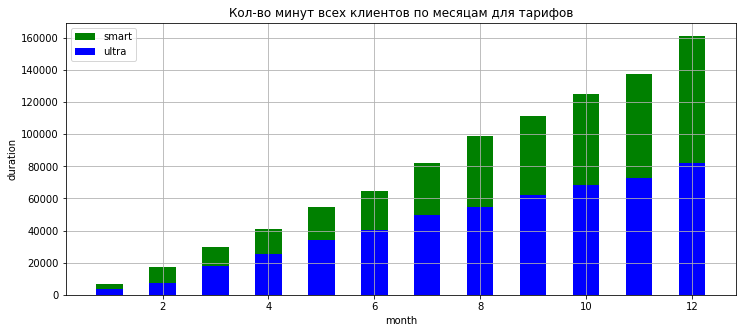

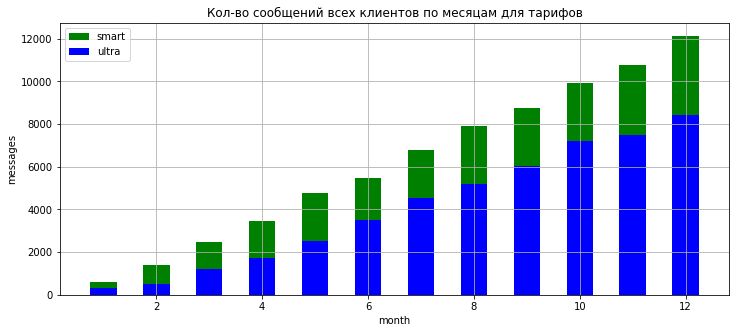

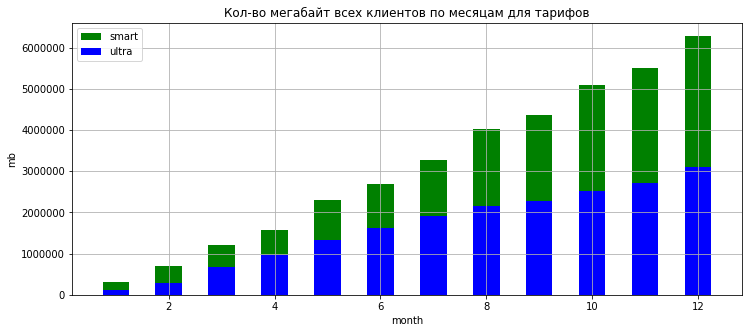

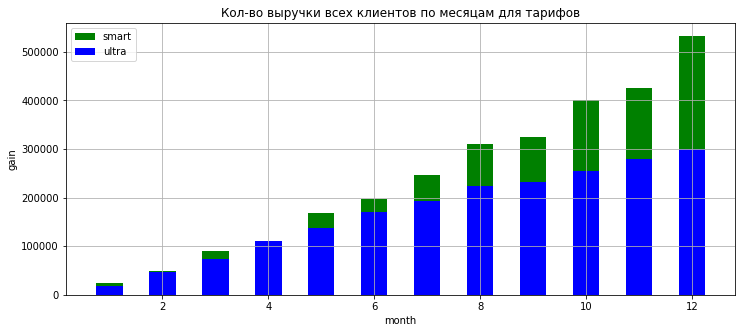

In [55]:
dict = {0 : 'минут',
       1 : 'сообщений',
       2 : 'мегабайт',
       3 : 'выручки'}
i = 0
for param in ['duration', 'messages', 'mb', 'gain']:
    plt.figure(figsize=(12, 5))
    plt.bar(smart_clients['month'], smart_clients[param], label='smart', color='g', width=0.5)
    plt.bar(ultra_clients['month'], ultra_clients[param], label='ultra', color='b', width=0.5)

    plt.xlabel('month')
    plt.ylabel(param)
    plt.grid()
    plt.title(f'Кол-во {dict[i]} всех клиентов по месяцам для тарифов')
    plt.legend()
    plt.show();
    i+=1

По графикам видно, что в абсолютном выражении общий расход у тарифа "smart", однако пользователей тарифа "ultra" в два раза меньше, чем пользователей тарифа "smart". Для оценки и выбора наиболее прибыльного тарифа надо посчитать усредненные показатели прибыли на клиента за каждый месяц.

Сгруппируем по месяцам и тарифам новую таблицу с медианными значениями и сразу разделим по разным тарифам

In [56]:
median_abonent_tarriff = abonents.groupby(['tariff', 'month'])['duration', 'messages', 'mb', 'gain'].median().reset_index()
display(median_abonent_tarriff)

,tariff,month,duration,messages,mb,gain
0,smart,1.0,162.5,15.0,7168.0,550.0
1,smart,2.0,258.0,20.0,13312.0,550.0
2,smart,3.0,409.0,23.0,16384.0,886.0
3,smart,4.0,368.5,28.0,14336.0,620.5
4,smart,5.0,433.0,30.0,16384.0,986.0
5,smart,6.0,400.0,28.0,16384.0,950.0
6,smart,7.0,414.0,29.0,16384.0,981.0
7,smart,8.0,432.0,27.0,17408.0,1079.0
8,smart,9.0,435.0,30.0,16384.0,958.5
9,smart,10.0,427.5,30.0,17408.0,1150.0


In [57]:
median_smart_clients = median_abonent_tarriff[median_abonent_tarriff['tariff']=="smart"]
median_ultra_clients = median_abonent_tarriff[median_abonent_tarriff['tariff']=="ultra"].reset_index(drop=True)

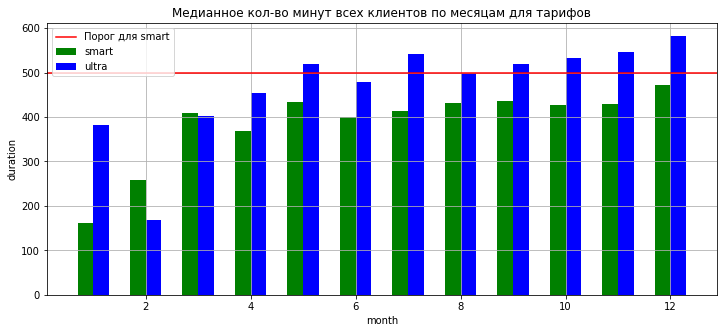

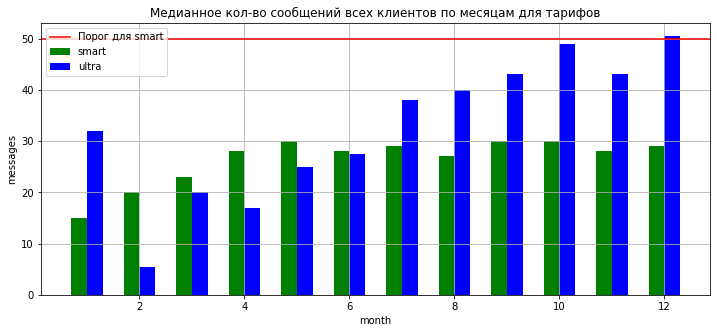

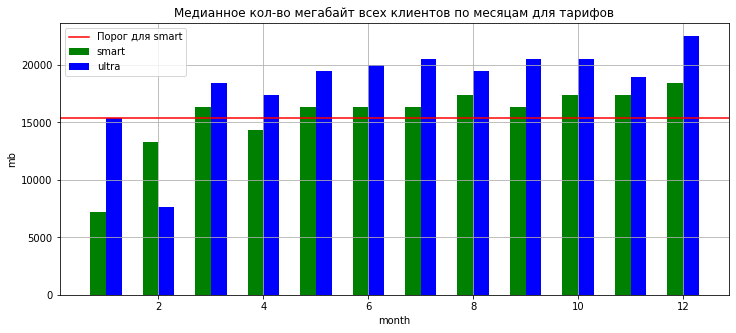

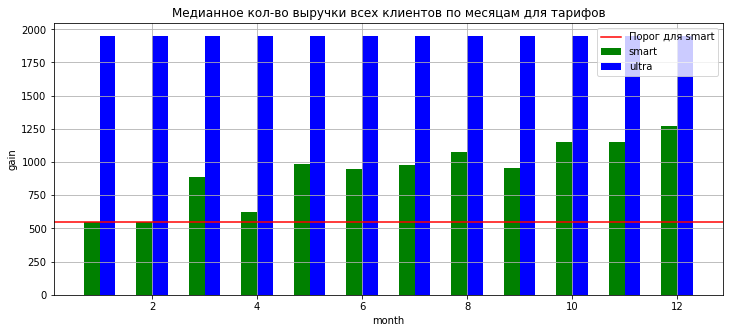

In [58]:
dict = {0 : 'минут',
       1 : 'сообщений',
       2 : 'мегабайт',
       3 : 'выручки'}
i = 0
for param in ['duration', 'messages', 'mb', 'gain']:
    plt.figure(figsize=(12, 5))
    plt.bar(median_smart_clients['month']-0.15, median_smart_clients[param], label='smart', color='g', width=0.3)
    plt.bar(median_ultra_clients['month']+0.15, median_ultra_clients[param], label='ultra', color='b', width=0.3)
    
    if param == 'duration':
        porog_smart=500
        porog_ultra=3000
    elif param == 'messages':
        porog_smart=50
        porog_ultra=1000
    elif param == 'mb':
        porog_smart=15360
        porog_ultra=30720
    else:
        porog_smart=550
        porog_ultra=1950
    
    plt.axhline(y=porog_smart, label='Порог для smart', color='r')
    #plt.axhline(y=porog_ultra, label='Порог для smart', color='r')
    plt.xlabel('month')
    plt.ylabel(param)
    plt.grid()
    plt.title(f'Медианное кол-во {dict[i]} всех клиентов по месяцам для тарифов')
    plt.legend()
    plt.show();
    i+=1

Медианные значения за год

In [59]:
i = 0
for param in ['duration', 'messages', 'mb', 'gain']:
    print(f'Кол-во {dict[i]}: smart = {round(median_smart_clients[param].median())}    ultra = {round(median_ultra_clients[param].median())}')
    i += 1

Кол-во минут: smart = 421    ultra = 510
Кол-во сообщений: smart = 28    ultra = 35
Кол-во мегабайт: smart = 16384    ultra = 19456
Кол-во выручки: smart = 970    ultra = 1950


Построим гистограммы распределения клиентов по объемам услуг

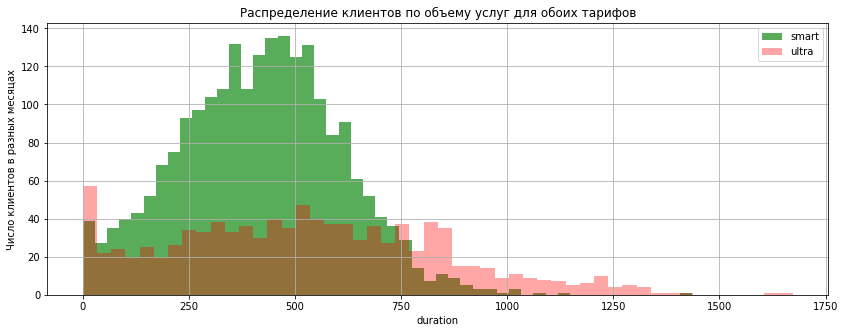

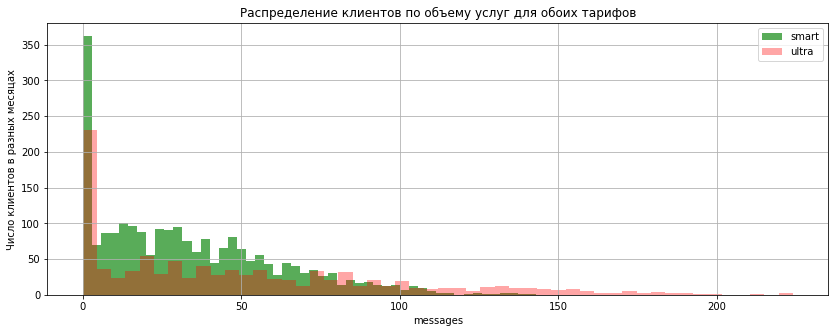

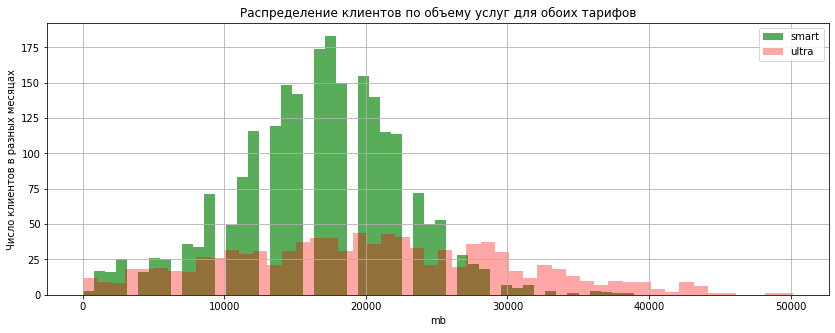

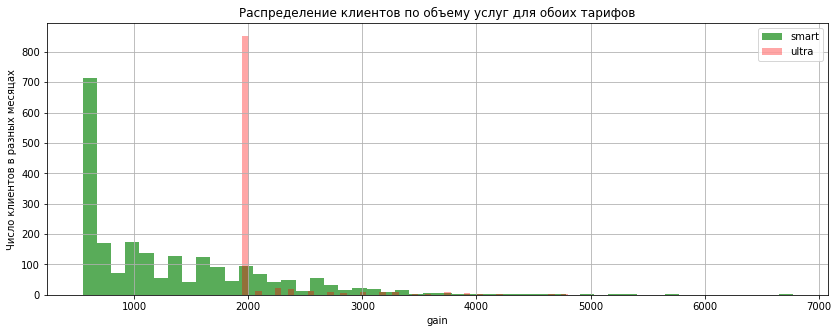

In [60]:
i = 0
for param in ['duration', 'messages', 'mb', 'gain']:
    plt.figure(figsize=(14, 5))
    
    plt.hist(abonents.loc[abonents['tariff'] == "smart", param], label='smart', color='g', alpha=0.65, bins = 50)
    plt.hist(abonents.loc[abonents['tariff'] == "ultra", param], label='ultra', color='r', alpha=0.35, bins = 50)
    
    plt.ylabel('Число клиентов в разных месяцах')
    plt.xlabel(param)
    plt.grid()
    plt.title(f'Распределение клиентов по объему услуг для обоих тарифов')
    plt.legend()
    plt.show();

Посчитаем среднее количество дисперсию и стандартное отклонение для каждого тарифа. Создадим для этого отдельный датафрейм.

In [61]:
smart_abonents = abonents[abonents['tariff']=="smart"]
ultra_abonents = abonents[abonents['tariff']=="ultra"].reset_index(drop=True)

In [62]:
stat = pd.DataFrame(columns = ['tariff', 'parameter', 'median', 'mean', 'var', 'std'])

ind = 0
names = ['smart', 'ultra']
for param in ['duration', 'messages', 'mb', 'gain']:
    i = 0
    for df in [smart_abonents, ultra_abonents]:
        stat.loc[ind, 'parameter'] = param
        stat.loc[ind, 'median'] = round(df[param].median(),1)
        stat.loc[ind, 'mean'] = round(df[param].mean(),1)
        stat.loc[ind, 'var'] = round(np.var(df[param], ddof=1),1)
        stat.loc[ind, 'std'] = round(np.std(df[param], ddof=1),1)
        stat.loc[ind, 'tariff'] = names[i]
        ind +=1
        i +=1
stat

,tariff,parameter,median,mean,var,std
0,smart,duration,421.5,417.7,36281.4,190.5
1,ultra,duration,518,526.1,101052,317.9
2,smart,messages,28,33.4,797,28.2
3,ultra,messages,38,49.3,2285.4,47.8
4,smart,mb,17408,16713.2,3.47429e+07,5894.3
5,ultra,mb,19456,19942,1.02109e+08,10104.9
6,smart,gain,1021,1289.6,669731,818.4
7,ultra,gain,1950,2070,141388,376


В последнем столбце для тарифа ultra медианная выручка по всем месяцам одинаковая, равная абонентской плате, что говорит о том, что пользователи тарифа редко платят за доп. услуги.

Также можно заметить, что стандартное отклонение у сообщений довольно большие, что связано с тем, что существует большое количество пользователей, которые практически не отправляют сообщения, что видно по гистограмме, распределение получается очень растянутым.

**Вывод**

В тарифе smart больщая часть пользователей укладывается в пределы тарифа, медианное значение по всем месяцам ниже предела в 500 минут. В тарифе ultra медианное значение значительно ниже предела в 3000 минут. Общее число израсходованных минут, сообщений и МБ растет на протяжении всего года из-за увеличения числа пользователей в течении года.

Можно сделать вывод также о том, что в нынешнее время очень мало людей пользуются СМС-сообщениями. Это связано с повсеместным расспространением мессенджеров, которые значительно удобнее СМС. Абоненты обоих тарифов вполне себе укладываются в свои пределы. В среднем абоненты обоих тарифов укладываются даже в 50 сообщений.

Если рассматривать интернет, то пользователи тарифа smart довольно часто докупают дополнительные Гб. Медианное значение использованных Мб около 16073 МБ. Медианное значение для тарифа ultra - 18831 МБ. если также рассмотреть медианные значения по месяцам, то оно колеблется от 11 до 23 ГБ. Предел в 30 ГБ довольно редко превышается.

Если рассмотреть графики по выручке можно заметить следующие закономерности:
- Пользователи тарифа ultra в большинстве случаев не выходит за пределы тарифа и платят только абонентскую плату;
- Пользователи тарифа smart наоборот довольно часто переплачивают за доп. функции (в основном за счет интернета).

Пользователи тарифа ultra значительно недоиспользуют свой тариф и за счёт этого переплачивают деньги. Для оператора этот тариф выгоднее, однако мало кто согласится на него переходить за счет высокой абонентской платы и избыточного объема услуг.

## Шаг 5. Проверка гипотез

Гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [63]:
smart_gain = abonents[abonents['tariff'] == 'smart']['gain'].values
ultra_gain = abonents[abonents['tariff'] == 'ultra']['gain'].values

Дисперсии для smart и ultra

In [64]:
print('Дисперсия тарифа smart', np.var(smart_gain))
print('Дисперсия тарифа ultra', np.var(ultra_gain))

Дисперсия тарифа smart 669430.4361979931
Дисперсия тарифа ultra 141244.31956107615


Дисперсии довольно сильно отличаются друг от друга.

- Нулевая гипотеза H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;
- Альтернативная гипотеза H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [65]:
alpha = 0.05
results = st.ttest_ind(smart_gain, ultra_gain, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


**Вывод**

Вероятность получить такую разницу между средними выборок при равенстве средних генеральных совокупностей практически равна нулю. Нулевую гипотезу можно отвергнуть. То есть гипотеза № 1 подтверждается и можно утверждать, что средняя выручка пользователей тарифов "Ультра" и «Смарт» различаются.

Выделим отдельно абонентов из Москвы и остальных городов

In [66]:
moscow_gain = abonents[abonents['city'] == "Москва"]['gain'].values
other_gain = abonents[abonents['city'] != "Москва"]['gain'].values

Для этих выборок дисперсии можно считать равными

- Нулевая гипотеза H0 - средняя выручка пользователей из Москвы и из других городов равны;
- Альтернативная гипотеза H1 - средняя выручка пользователей из Москвы и из других городов различается.

In [67]:
results = st.ttest_ind(moscow_gain, other_gain, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


Вероятность равенства средних генеральных совокупностей высокое, поэтому нулевую гипотезу нельзя отвергать. Гипотеза № 2 не подтверждается

## Шаг 6. Общий вывод

Данные изначально были в порядке, поэтому в процессе предобработки были изменены типы данных только для дат. Данные были корректны и дубликатов не было.

Были рассмотрены данные по объемам услуг. Определено сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Оценены средние значения, дисперсии и стандартные отклонения. Построены гистограммы.

В процессы анализа были определены следующие закономерности:

- В тарифе smart больщая часть пользователей укладывается в пределы тарифа, медианное значение по всем месяцам ниже предела в 500 минут. В тарифе ultra медианное значение значительно ниже предела в 3000 минут. Общее число израсходованных минут, сообщений и МБ растет на протяжении всего года из-за увеличения числа пользователей в течении года.

- Можно сделать вывод также о том, что в нынешнее время очень мало людей пользуются СМС-сообщениями. Это связано с повсеместным расспространением мессенджеров, которые значительно удобнее СМС. Абоненты обоих тарифов вполне себе укладываются в свои пределы. В среднем абоненты обоих тарифов укладываются даже в 50 сообщений.

- Если рассматривать интернет, то пользователи тарифа smart довольно часто докупают дополнительные Гб. Медианное значение использованных Мб около 16073 МБ. Медианное значение для тарифа ultra - 18831 МБ. если также рассмотреть медианные значения по месяцам, то оно колеблется от 11 до 23 ГБ. Предел в 30 ГБ довольно редко превышается.

Если рассмотреть графики по выручке можно заметить следующие закономерности:
- Пользователи тарифа ultra в большинстве случаев не выходит за пределы тарифа и платят только абонентскую плату;
- Пользователи тарифа smart наоборот довольно часто переплачивают за доп. функции (в основном за счет интернета).

Пользователи тарифа ultra значительно недоиспользуют свой тариф и за счёт этого переплачивают деньги. Для оператора этот тариф выгоднее, однако мало кто согласится на него переходить за счет высокой абонентской платы и избыточного объема услуг.

Были проверены две гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Первая гипотеза подтвердилась, а вторая - нет.

Так как цель исследования - это определение наиболее прибыльного тарифа, попробуем ответить на этот вопрос. Если рассмотреть столбчатые диаграммы по общим доходам, то видно, что в общем тариф смарт приносит больше прибыли, чем ультра. Это объясняется большей привлекательностью этого тарифа в глазах среднего пользователя, так как пределы этого тарифа более близки к средним месячным потребностям пользователей (кроме интернета). По тарифу ультра можно сказать, что пользователи переплачивают за лишний объем услуг и редко превышают пакетный объем услуг, отсюда и меньшая его привлекательность в глазах пользователей. Предлагаю сосредоточить усилия на тарифе смарт, так как в перспективе он позволит привлечь гораздо больше пользователей, чем ультра, а при сохраняющейся тенденции к увеличению среднемесячного потребления услуг приведет и к увеличению выручке за счет продажи дополнительных услуг пользователям